In this assignment you have to experiment with letter-to-phoneme conversion. This task is an important part of speech technologies including recognition and synthesis.

The language is French, but you are not expected to know French to do well in this task.

Let's first download the data:

In [ ]:
! wget --no-check-certificate https://bark.phon.ioc.ee/tanel/tmp/fre_train.tsv
! wget --no-check-certificate https://bark.phon.ioc.ee/tanel/tmp/fre_dev.tsv
! wget --no-check-certificate https://bark.phon.ioc.ee/tanel/tmp/fre_test.unlabelled.tsv

--2023-04-26 08:01:05--  https://bark.phon.ioc.ee/tanel/tmp/fre_train.tsv
Resolving bark.phon.ioc.ee (bark.phon.ioc.ee)... 193.40.251.129
Connecting to bark.phon.ioc.ee (bark.phon.ioc.ee)|193.40.251.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79465 (78K) [text/tab-separated-values]
Saving to: ‘fre_train.tsv’

fre_train.tsv       100%[===================>]  77.60K   365KB/s    in 0.2s    

2023-04-26 08:01:05 (365 KB/s) - ‘fre_train.tsv’ saved [79465/79465]

--2023-04-26 08:01:05--  https://bark.phon.ioc.ee/tanel/tmp/fre_dev.tsv
Resolving bark.phon.ioc.ee (bark.phon.ioc.ee)... 193.40.251.129
Connecting to bark.phon.ioc.ee (bark.phon.ioc.ee)|193.40.251.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9925 (9.7K) [text/tab-separated-values]
Saving to: ‘fre_dev.tsv’

fre_dev.tsv         100%[===================>]   9.69K  --.-KB/s    in 0s      

2023-04-26 08:01:06 (139 MB/s) - ‘fre_dev.tsv’ saved [9925/9925]

--2023-04-26 08:

Let's explore the data:

In [ ]:
!head fre_train.tsv

abandonner	a b ɑ̃ d ɔ n e
abby	a b i
abidjan	a b i d ʒ ɑ̃
abject	a b ʒ ɛ k t
abolir	a b ɔ l i ʁ
abonnement	a b ɔ n m ɑ̃
abou	a b u
absence	a p s ɑ̃ s
absolument	a p s ɔ l y m ɑ̃
absolus	a p s ɔ l y


In [ ]:
!head fre_dev.tsv

absent	a p s ɑ̃
abîme	a b i m
accéder	a k s e d e
accélérer	a k s e l e ʁ e
achat	a ʃ a
action	a k s j ɔ̃
activité	a k t i v i t e
adorner	a d ɔ ʁ n e
agence	a ʒ ɑ̃ s
aile	ɛ l


In [ ]:
!head fre_test.unlabelled.tsv

tandis
serres
enfer
réunion
moderne
star
classique
bientôt
bouddhiste
défaut


As you see, the data consists of lines. On each line there is a word and its pronunciation, seperated by TABs. Pronunciation consists of IPA-like symbols, seperated by space. The test data is unlabelled, i.e., the pronunciations are not given.

We use the datasets package that is good for handling this kind of data.

In [ ]:
! pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 64.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.4/269.4 kB 26.8 MB/s eta 0:00:00


In [ ]:
import torch


In [ ]:
from datasets import load_dataset
# define field names for each column in the CSV files
field_names = ["chars", "phonemes"]
# load train, dev and test datasets from CSV files
data = load_dataset('csv', data_files={'train': 'fre_train.tsv', 'dev': 'fre_dev.tsv'}, delimiter='\t', column_names=field_names)

test_word_list = [l.strip() for l in open("fre_test.unlabelled.tsv")]



  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
data

DatasetDict({
    train: Dataset({
        features: ['chars', 'phonemes'],
        num_rows: 3600
    })
    dev: Dataset({
        features: ['chars', 'phonemes'],
        num_rows: 450
    })
})

In [ ]:
data["train"][0]["phonemes"]

'a b ɑ̃ d ɔ n e'

In [ ]:
# define a function to split both fields to a list of characters
def split_chars(example):
    example['chars'] = list(example['chars'])
    example['phonemes'] = example['phonemes'].split()
    return example

data = data.map(split_chars, batched=False)    

Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

In [ ]:
train_dataset = data["train"]
dev_dataset = data["dev"]


Let's explore the datasets:

In [ ]:
print(len(train_dataset))
print(train_dataset[0]["chars"], train_dataset[0]["phonemes"])

3600
['a', 'b', 'a', 'n', 'd', 'o', 'n', 'n', 'e', 'r'] ['a', 'b', 'ɑ̃', 'd', 'ɔ', 'n', 'e']


Now let's build the char-to-id and phoneme-to-id mappings.

In [ ]:
from torchtext.vocab import vocab
from torchtext.vocab import build_vocab_from_iterator

chars_vocab = build_vocab_from_iterator(train_dataset["chars"], min_freq=1, specials=('<unk>', '<BOS>', '<EOS>', '<PAD>'))
phoneme_vocab = build_vocab_from_iterator(train_dataset["phonemes"], min_freq=1, specials=('<unk>', '<BOS>', '<EOS>', '<PAD>'))

In [ ]:
chars_vocab.get_itos()

['<unk>',
 '<BOS>',
 '<EOS>',
 '<PAD>',
 'e',
 'r',
 'i',
 'a',
 'n',
 't',
 'o',
 's',
 'l',
 'c',
 'u',
 'm',
 'p',
 'é',
 'd',
 'g',
 'b',
 'v',
 'f',
 'h',
 'q',
 'x',
 'è',
 'y',
 'j',
 'k',
 'z',
 'ê',
 'ô',
 'î',
 'â',
 'ï',
 'ç',
 'w',
 'û',
 'ë',
 'à']

In [ ]:
phoneme_vocab.get_itos()

['<unk>',
 '<BOS>',
 '<EOS>',
 '<PAD>',
 'ʁ',
 'a',
 'i',
 's',
 't',
 'e',
 'l',
 'k',
 'ɛ',
 'ɔ',
 'ɑ̃',
 'p',
 'm',
 'd',
 'j',
 'n',
 'ɔ̃',
 'y',
 'v',
 'b',
 'f',
 'ʒ',
 'z',
 'ɛ̃',
 'u',
 'ə',
 'o',
 'ɡ',
 'w',
 'ʃ',
 'œ',
 'ɥ',
 'ø',
 'ɑ',
 'ɲ',
 'œ̃',
 'ŋ',
 'h',
 'ɪ',
 '‿']

In [ ]:
chars_vocab(["a", "b"])

[7, 20]

In [ ]:
chars_vocab["<PAD>"]

3

In [ ]:
device = 'cpu'
if torch.cuda.is_available():
  device = torch.device('cuda')

print(device)

cuda


Let's define the collate function for batching:

In [ ]:
import torch
from torch.nn.utils.rnn import pad_sequence

# define a collate function to tokenize and pad the text fields
def collate_fn(batch):
  chars = [torch.Tensor(chars_vocab(["<BOS>"]  + example['chars'] +  ["<EOS>"])).long() for example in batch]
  phonemes = [torch.Tensor(phoneme_vocab(["<BOS>"] +  example['phonemes'] + ["<EOS>"])).long() for example in batch]
  return {
    'chars': pad_sequence(chars, batch_first=True, padding_value=chars_vocab['<PAD>']),
    'phonemes': pad_sequence(phonemes, batch_first=True, padding_value=phoneme_vocab['<PAD>'])
  }

In [ ]:
collate_fn([train_dataset[0], train_dataset[1]])

{'chars': tensor([[ 1,  7, 20,  7,  8, 18, 10,  8,  8,  4,  5,  2],
         [ 1,  7, 20, 20, 27,  2,  3,  3,  3,  3,  3,  3]]),
 'phonemes': tensor([[ 1,  5, 23, 14, 17, 13, 19,  9,  2],
         [ 1,  5, 23,  6,  2,  3,  3,  3,  3]])}

Each batch is now a map with two keys (chars and phonemes) which each are both tensors (matrices).

We will first implement a basic encoder-decoder model for this task. Both encoder and decoder have an embedding layer and a recurrent (GRU) layer. The last hidden state of the GRU layer of the encoder is passed to the decoder, which then generates the pronunication from this representation.

The picture below describes this model: an input character sequence "abou" is transformed to a phoneme sequence "abu". Note how the outputs of the encoder GRU are completely ignored by the decoder.

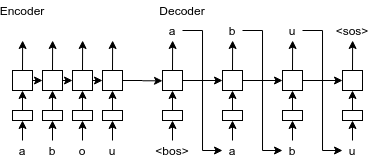

In [ ]:
import sys
import torch.nn as nn
import torch.nn.functional as F
import time
import random
import math

First, the encoder part of the seq2seq model:

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers):
        super().__init__()        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hid_dim, n_layers, batch_first=True)
        
    def forward(self, src):        
        # src: [batch size, seq_len]       
        embedded = self.embedding(src)
        #embedded: [batch_size, seq_len,  emb_dim]
        outputs, hidden = self.rnn(embedded)

        return hidden, outputs

Then, the decoder part:

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers):
        super().__init__()
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, hid_dim, n_layers, batch_first=True)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        
    def forward(self, input, hidden, encoder_outputs):            
        #input: [batch size]
        #hidden: [batch size, hid_dim]
        #encoder_outputs: [batch size, src_len, hid_dim]
        
        input = input.unsqueeze(1)
        #input: [batch size, 1]        
        embedded = self.embedding(input)
        #embedded: [batch size, 1, emb dim]
        output, hidden = self.rnn(embedded, hidden)        
        prediction = self.fc_out(output.squeeze(1))        
        #prediction: [batch size, output dim]
        
        return prediction, hidden

And finally, the seq2seq model:

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src: [batch size, src_len]
        #trg: [batch size, trg_len]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, encoder_outputs = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[:, 0]
        
        for t in range(1, trg_len):    
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            #place predictions in a tensor holding predictions for each token
            outputs[:, t, :] = output
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            #print("---", trg[:, t].shape, top1.shape)
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[:, t] if teacher_force else top1
        
        return outputs

Now, we implement the training routines:

In [ ]:
from tqdm.notebook import tqdm

def train_one_epoch(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    for i, batch in tqdm(enumerate(iterator)):
        src = batch["chars"].to(device)
        trg = batch["phonemes"].to(device)
        optimizer.zero_grad()
        output = model(src, trg)
        
        #trg: [trg_len, batch size]
        #output_ [trg_len, batch size, output dim]
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)

        #trg:  [(trg len - 1) * batch size]
        #output: [(trg len - 1) * batch size, output dim]
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = batch["chars"].to(device)
            trg = batch["phonemes"].to(device)
            output = model(src, trg, 0) #turn off teacher forcing
            #trg: [trg len, batch size]
            #output: [trg len, batch size, output dim]
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            #trg: [(trg len - 1) * batch size]
            #output: [(trg len - 1) * batch size, output dim]
            loss = criterion(output, trg)
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
from torch.utils.data import DataLoader


def train(model, num_epochs, clip):
  optimizer = torch.optim.Adam(model.parameters())
  criterion = nn.CrossEntropyLoss(ignore_index=phoneme_vocab["<PAD>"])
  
  train_iter = DataLoader(train_dataset, batch_size=32, collate_fn=collate_fn, shuffle=True)
  dev_iter = DataLoader(dev_dataset, batch_size=32, collate_fn=collate_fn)

  for epoch in range(num_epochs):
      start_time = time.time()
      train_loss = train_one_epoch(model, train_iter, optimizer, criterion, clip)
      valid_loss = evaluate(model, dev_iter, criterion)
      end_time = time.time()
      epoch_mins, epoch_secs = epoch_time(start_time, end_time)
      
      print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
      print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
      print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Finally we can train our baseline model:

In [ ]:
INPUT_DIM = len(chars_vocab)
OUTPUT_DIM = len(phoneme_vocab)
ENC_EMB_DIM = 100
DEC_EMB_DIM = 100
HID_DIM = 256
N_LAYERS = 1

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS)

model = Seq2Seq(enc, dec, device).to(device)

N_EPOCHS = 10

CLIP = 1.0

train(model, N_EPOCHS, CLIP)


0it [00:00, ?it/s]

Epoch: 01 | Time: 0m 2s
	Train Loss: 3.014 | Train PPL:  20.377
	 Val. Loss: 2.961 |  Val. PPL:  19.318


0it [00:00, ?it/s]

Epoch: 02 | Time: 0m 3s
	Train Loss: 2.454 | Train PPL:  11.632
	 Val. Loss: 2.451 |  Val. PPL:  11.606


0it [00:00, ?it/s]

Epoch: 03 | Time: 0m 1s
	Train Loss: 1.940 | Train PPL:   6.960
	 Val. Loss: 2.008 |  Val. PPL:   7.451


0it [00:00, ?it/s]

Epoch: 04 | Time: 0m 1s
	Train Loss: 1.545 | Train PPL:   4.686
	 Val. Loss: 1.730 |  Val. PPL:   5.638


0it [00:00, ?it/s]

Epoch: 05 | Time: 0m 1s
	Train Loss: 1.265 | Train PPL:   3.542
	 Val. Loss: 1.499 |  Val. PPL:   4.477


0it [00:00, ?it/s]

Epoch: 06 | Time: 0m 1s
	Train Loss: 1.074 | Train PPL:   2.926
	 Val. Loss: 1.367 |  Val. PPL:   3.923


0it [00:00, ?it/s]

Epoch: 07 | Time: 0m 1s
	Train Loss: 0.941 | Train PPL:   2.563
	 Val. Loss: 1.278 |  Val. PPL:   3.590


0it [00:00, ?it/s]

Epoch: 08 | Time: 0m 1s
	Train Loss: 0.852 | Train PPL:   2.345
	 Val. Loss: 1.168 |  Val. PPL:   3.214


0it [00:00, ?it/s]

Epoch: 09 | Time: 0m 2s
	Train Loss: 0.760 | Train PPL:   2.139
	 Val. Loss: 1.208 |  Val. PPL:   3.347


0it [00:00, ?it/s]

Epoch: 10 | Time: 0m 1s
	Train Loss: 0.715 | Train PPL:   2.043
	 Val. Loss: 1.149 |  Val. PPL:   3.156


Now, we implement a function that applies the model to a given string:

In [ ]:
def chars2phonemes(word, model, max_len=50):
    model.eval()
    chars = torch.Tensor([chars_vocab(["<BOS>"] + list(word) + ["<EOS>"])]).long().to(device)    
    with torch.no_grad():
        hidden, encoder_outputs = model.encoder(chars)
    trg_indexes = [phoneme_vocab["<BOS>"]]

    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
        with torch.no_grad():
            output, hidden = model.decoder(trg_tensor, hidden, encoder_outputs)
        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)
        if pred_token == phoneme_vocab["<EOS>"]:
            break
    
    trg_tokens = [phoneme_vocab.get_itos()[i] for i in trg_indexes]
    
    return " ".join(trg_tokens[1:-1])

In [ ]:
chars2phonemes("appartement", model)

'a p a ʁ t ə m ɑ̃'

This should be a correct pronunciation ('a p a ʁ t ə m ɑ̃').

Now, we implement scoring functionality that allows to evaluate our model based on *phoneme error rate* (how many phonemes in the output are correct, compared to the reference). We use the implementation in jiwer package. The appropriate function is called `wer` (word error rate) because this is typically used to measure the word error rate of a speech recognition system.

In [ ]:
! pip install jiwer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 49.1 MB/s eta 0:00:00


In [ ]:
import jiwer
ref = "a b a c"
hyp = "a b a d"
jiwer.wer(ref, hyp)

0.25

Both substitution, insertion and deletion errors are taken into account when computing WER:

In [ ]:
ref = "a b a c"
hyp = "a b a a c"
jiwer.wer(ref, hyp)

0.25

In [ ]:
ref = "a b a c"
hyp = "a b c"
jiwer.wer(ref, hyp)

0.25

Finally, the function that computes the scoring metrics based on the development set:

In [ ]:
def per(model):
  refs = [] 
  hyps = []
  for item in iter(dev_dataset):
    ref = " ".join(item["phonemes"])
    hyp = chars2phonemes("".join(item["chars"]), model)
    refs.append(ref)
    hyps.append(hyp)

  per = jiwer.wer(refs, hyps)
  print(f"Phoneme error rate: {per}")

In [ ]:
per(model)

Phoneme error rate: 0.19855884707766214


Finally, we implement a function that applies the model to our test data and saves it is a file called `submission.tsv`.

In [ ]:
def make_submission(model):
  with open("submission.tsv", "w") as f:
    print("Word\tPhonemes", file=f)
    for word in test_word_list:
      hyp = chars2phonemes(word, model)
      print(f"{word}\t{hyp}", file=f)


In [ ]:
make_submission(model)

In [ ]:
!head submission.tsv

Word	Phonemes
tandis	t ɑ̃ d i
serres	s ɛ ʁ
enfer	ɑ̃ f ɛ ʁ
réunion	ʁ e y n i z ɔ̃
moderne	m ɔ d ɛ ʁ
star	s t a ʁ
classique	k a l s k a
bientôt	b j ɑ̃ t
bouddhiste	b u d d i s t


## Your assignment

Your task is to improve the performance of the baseline model. You can use any method do this, with the following exceptions:
  * You cannot use some some pretrained model that you found on the Internet that already does this task
  * You cannot use additional French data for training
  * You have to stick to basic Pytorch, and not use libraries that implement whole models for you (you can copy/paste code from there though, as long as you understand what this code is doing)
  * You cannot hand-label additional data
  * You are not allowed to fold the dev set into training data

Some things you can do:

  * Tune basic learning hyperparametes, such as number of epochs, learning rate, optimizer
  * Tune model architecture (number of outputs in the layers, number of layers, etc)
  * Add regularization (dropout, etc)

But the most lucrative thing to try is to implement attention mechanism.  In the baseline model, decoder has to generate a pronunciation solely based on the hidden state passed from the encoder.

You should try to implement attention mechanism between the encoder and decoder.

More specifically, decoder should at each time step generate a new weighted view over the encoder GRU outputs (that are luckily already passed to the decoder's forward method). You should use the query-key-value based attention: output from the decoder's GRU is passed through a (learnable) linear transform that results in a query vector $q$. Another linear transform is applied to encoder outputs that results in key vectors $k_i$. Note that query and keys should have the same dimensionality. Now the query is compared to the keys (using dot product) and the results is softmaxed, resulting in attention weights $w_i$ over the encoder outputs. Encoder outputs are now passed through another linear transform (resulting in $v_i$ ) and summed up to form $v*$, using the computed weights. 


Luckily, most of the attention functionality is implemented in torch's `nn.MultiheadAttention` class. You just have to take care of the linear transforms and some other stuff.

The picture below describes this. Note how how the decoder generates a character "a" based on the output from it's GRU *and* the output $v*$ from the attention mechanism.

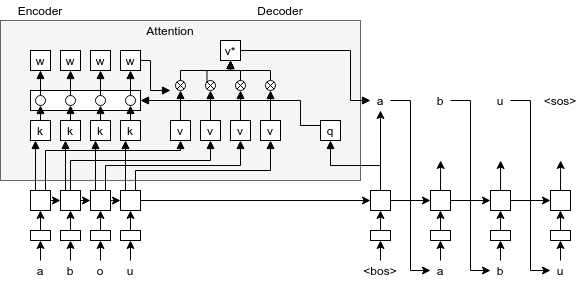

You only need modify the Decoder to implement this. 



If implemented correctly, your phoneme error rate around 0.04 ... 0.08 (actually different training runs give quite different results). That is, attention really works very well in this task, compared to the more basic models.

**Another thing that you should try is to use the Transformer architecture**, i.e., get rid of the GRU layers in both encoder and decoder completely. You should also then use positional encoding in both encoder and decoder. There are plenty of tutorials and code samples about this, and see our lab about Machine Translation!



## Grading

In order to be graded, you have to submit the generated test pronunciations (i.e., the `submission.tsv` file generated by you improved model) to the evaluation leaderboard at http://bark.phon.ioc.ee/am3-leaderboard/. 

In the leaderboard, you have to enter your UniID and upload the generated `submission.tsv` file. *NB!* If you don't feel comfortable that other students see your score, use a nickname (i.e., could be random string only you know), but please be consistent, that is, use only one name across all your submissions. If you use a nickname, let me know what it is when you submit your code.

*Another NB!* The leaderboard is totally unsecure and you don't even have to authenticate yourself, so please don't do stupid things, like uploading under other people's names, etc.

Your grade is determined by the error rate of your best model on test data, compared to the average score of the top 3 students. 

More specifially:
  * First, the average of the top 3 students' models will be computed. Let's call it $score_{top3}$. Let's also save the error rate of the baseline model to $score_{baseline}$.
  * Then, we'll compute how much of the error rate reduction does your best score $score_i$ achieve  over the baseline, when baseline would give you 0% points and $score_{top3}$ 100% points. 
  * That is, your points will be calculated as $max(15, \delta * 15)$, where 
  $\delta=\frac{score_{baseline} - score_{i}}{score_{baseline} - score_{top3}}$
  * For example: baseline score is 0.18, top3 average  is 0.07, and your score 0.11. This would give you $\delta=\frac{0.18-0.11}{0.18-0.07}=0.63$ and $0.63 \times 15 = 9.6 ≃ 10$ points.
  


### More rules!

  * You can make *up to 20 submissions* to the leaderboard
  * The leaderboard $score_{top3}$ will be taken at the time of the assignment deadline. Later submissions that make it to the top 3 will not change it.

You should also submit the jupyter notebook (link) that reproduces your best model. Note that it's expected that multiple runs of the training won't have the same results. 

Please make sure that you share your notebook's link so that "anyone with the link" can see it.